# Magnitude structure for minimizing negative transfer of knowledge in MOGP


Given a number of outputs $M=3$, each one with $Q_{\text{unique}}=3$ latent components, with $Q_{\text{pair}}=1$  pairwise components and $Q_{\text{shared}}=2$ shared components.

This leads to a total of 

\begin{align}
Q_{\text{total}} & = M * Q_u + \binom{M}{2} Q_p + Q_s \\
Q_{\text{total}} & = 3 * 3 + 3 * 1 * + 2 = 14
\end{align}

With this, a binary matrix with the weights has the form:

## TODO

* make so that the MAE is obtained only in the test points
* more iter on rmosm ????

In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_probability as tfp

import mogptk
from mogptk.restricted_mosm import _create_mask

import matplotlib as mpl

# TODO: remove when done:
%reload_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns

In [3]:
plt.rcParams['figure.figsize'] = (12, 4)

sns.set_context('paper', font_scale=1.5)
sns.set_style('ticks')

# Experiment with asymmetrical task and synthetic data

In order to assert the effectiveness of the model to mitigate negative transfer of knowledge, we use a controlled setup with synthetic data. Replicating the experiment in [Lenn 2012](https://link.springer.com/content/pdf/10.1007/s10994-012-5302-y.pdf).
In this multioutput regression problem, the goal will be to reconstuct a particular channel, denoted primary task or channel, whilst the other channels will help the regression, denoted secondary task. 10 secondary channels will be created, where not all will contain a dependence with the primary task.

For this will create the **primary** regression task $f_p$ sampled from a GP with SE kernel and lenghtscale $\ell=0.5$. 

$$f_p \sim \mathcal{GP}(0, K_p)$$

Whereas the secondary task, denoting $f_{s_i}$ the $i$-th secondary task, it will be sampled according to:

$$f_n \sim \mathcal{GP(0, K_n)}$$

$$f_{s_i} \sim \mathcal{GP}\left( (s-1) a_i f_p  + s a_i f_n,   b_i K_{s_i} \right)$$

Where $s\in {0, 1}$, and $a_i, b_i$ are sampled from a uniform in $[0, 1]$



In [4]:
def k_se(x1, x2, sigma_2=1, l=1):
    """
    Squared exponential kernel
    """
    gamma = 1/l**2
    tau = np.subtract.outer(x1, x2)
    
    gram = np.exp(- gamma * tau**2)
    
    return sigma_2 * gram

def sample_gp_se(x, sigma_2=1, l=1):
    """
    Sample GP with SE kernel
    """
    gram = k_se(x, x, sigma_2, l)
    
    return np.random.multivariate_normal(np.zeros_like(x), gram)

In [5]:
def create_asymmetric_tasks(x, f_p, l_s=1/3, l_u=0.5, s=5, n_s=5):
    """
    Sample from the primary and 
    secundary tasks.
    
    x_p = primary input
    x_s = secondary input 
    l_s = shared lengthscale
    l_u = unrelated lengthscale
    n_s = number of secundary task with 
        useful information
    """
    f_s = sample_gp_se(x, l=l_s)
    
    task_list = np.zeros((n_s, len(x)))
    
    for i in range(n_s):
#         a = np.random.random()
        a = 1
        b = np.random.random()
        
        if i < s:
            task_i = f_p * a
        else:
            task_i = f_s * a
        task_i += sample_gp_se(x, b, l_u)
        task_i += np.random.normal(scale=0.1, size=len(task_i))
        task_list[i, :] = task_i

    return task_list


### Create data

In [6]:
np.random.seed(123)

t = np.linspace(0, 10, 150)
n_s = 5

l_p = 0.5
sigma_n = 0.4
f_p = sample_gp_se(t, l=l_p)
y_p = f_p + np.random.normal(scale=sigma_n, size=len(t))

secondary_tasks = create_asymmetric_tasks(t, f_p, n_s=n_s, s=3)

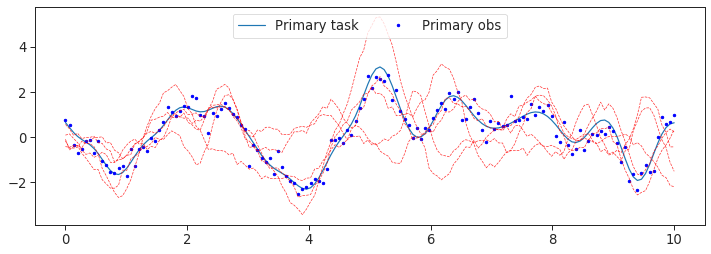

In [7]:
plt.figure(figsize=(12, 4))

plt.plot(t, f_p, label='Primary task')
plt.plot(t, y_p, '.b', label='Primary obs')

for i in range(n_s):
    plt.plot(t, secondary_tasks[i], '--r', lw=0.7, alpha=0.8)
# plt.plot(t, sec_task.mean(0), 'r', label='Mean of sec task')
plt.legend(ncol=2, loc='upper center')

In [8]:
np.random.seed(123)
dataset = mogptk.DataSet(mogptk.Data(t, y_p))

for i in range(n_s):
    dataset.append(mogptk.Data(t, secondary_tasks[i, :]))

size = int(0.85 * len(t))
np.random.seed(123)
index = np.random.choice(np.arange(len(t)), size=size, replace=True)

dataset[0].remove_index(index)

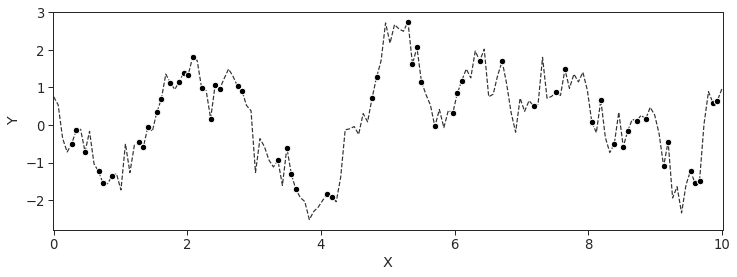

In [9]:
plt.figure(figsize=(12, 4))
dataset[0].plot()

## Baseline with SM kernel

In [10]:
model = mogptk.SM(dataset[0], Q=1)
model.init_parameters()

model.train(maxiter=1000, tol=1e-10, verbose=True)

Starting optimization
 >Model: SM
 >Channels: 1                    
 >Components: 1
 >Training points: 57
 >Parameters: 4
 >Initial NLL: 75.912
Optimization finished in 0.15 minutes
 >Final NLL: 53.145 



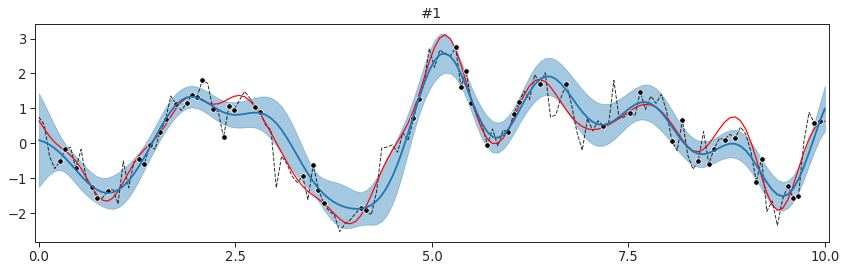

In [11]:
y_pred, _, _ = model.predict(t)

fig, ax = model.plot_prediction(figsize=(12, 4))
ax[0].plot(t, f_p, 'r')

In [12]:
np.abs(y_pred - f_p).mean()

0.27012126642382117

## MOSM

In [ ]:
mosm = mogptk.MOSM(dataset, Q=1)

mosm.init_parameters()

In [ ]:
mosm.train(maxiter=1000, tol=1e-20, verbose=True)

In [ ]:
mosm.predict([t]*(n_s + 1))
fig, ax = mosm.plot_prediction();
ax[0].plot(t, f_p, 'r', alpha=0.7)

## R-MOSM with shared component

In [ ]:
M = len(dataset)
Q_u = np.array([0] + [1] * n_s)
Q_p = 0
Q_s = 1

# prior = tfp.distributions.Laplace(loc=np.zeros(M), scale=np.ones(M) * 20)
prior = None
rmosm = mogptk.RMOSM(dataset, Q_u=Q_u, Q_p=Q_p, Q_s=Q_s, magnitude_prior=prior)

rmosm.init_parameters()

In [ ]:
rmosm.train(maxiter=1000, tol=1e-20, verbose=True)

In [ ]:
rmosm.predict([t] * (n_s + 1))

fig, ax = rmosm.plot_prediction();
ax[0].plot(t, f_p, 'r', alpha=0.7)

## R-MOSM with pairwise components

In [ ]:
M = len(dataset)
Q_u = np.array([0] + [1] * n_s)
Q_p = 1
Q_s = 0

# prior = tfp.distributions.Laplace(loc=np.zeros(M), scale=np.ones(M) * 20)
prior = None
rmosm2 = mogptk.RMOSM(dataset, Q_u=Q_u, Q_p=Q_p, Q_s=Q_s, magnitude_prior=prior)

rmosm2.init_parameters()
rmosm2.train(maxiter=1000, tol=1e-20, verbose=True)

In [ ]:
rmosm2.predict([t]*(n_s + 1))

fig, ax = rmosm2.plot_prediction();
ax[0].plot(t, f_p, 'r', alpha=0.7)

# Experiment with repetitions

For each model, we will run 5 experiments with 5 secondary tasks, varing the the number of secondary tasks that have useful information from 0 to 5 for each experiment.

## BASELINE: SM kernel on primary task

#### Creation of noisy version of signal

In [10]:
np.random.seed(123)
y_p = f_p + np.random.normal(scale=0.4, size=len(t))

size = int(0.8 * len(t))
np.random.seed(123)
index = sorted(np.random.choice(np.arange(len(t)), size=size, replace=True))
index2 = np.arange(74, 85)

In [11]:
def make_dataset(t, f_p, y_p, sigma_n, n_s, s):
    sec_tasks = create_asymmetric_tasks(t, f_p, n_s=n_s, s=s)
    
    dataset = mogptk.DataSet(mogptk.Data(t, y_p))
    for i in range(5):
        dataset.append(mogptk.DataSet(mogptk.Data(t, sec_tasks[i])))
    
    return dataset

In [12]:
n_trials = 2
sm_mae = np.zeros(n_trials)

for n in range(n_trials):
    data = mogptk.Data(t, y_p)
    data.remove_index(index)
    data.remove_index(index2)
    
    model = mogptk.SM(data, Q=1)
    model.init_parameters()
    model.train(tol=1e-10, maxiter=1000, verbose=True)
    
    y_pred, _, _ = model.predict(t)
    
    sm_mae[n] = np.abs(y_pred[0] - f_p).mean()
    
    
np.savetxt('r-mosm_comparison/13-04/sm.csv', sm_mae, delimiter=',')

Starting optimization
 >Model: SM
 >Channels: 1                    
 >Components: 1
 >Training points: 55
 >Parameters: 4
 >Initial NLL: 74.594
Optimization finished in 0.22 minutes
 >Final NLL: 56.927 

Starting optimization
 >Model: SM
 >Channels: 1                    
 >Components: 1
 >Training points: 55
 >Parameters: 4
 >Initial NLL: 74.594
Optimization finished in 0.01 minutes
 >Final NLL: 56.927 



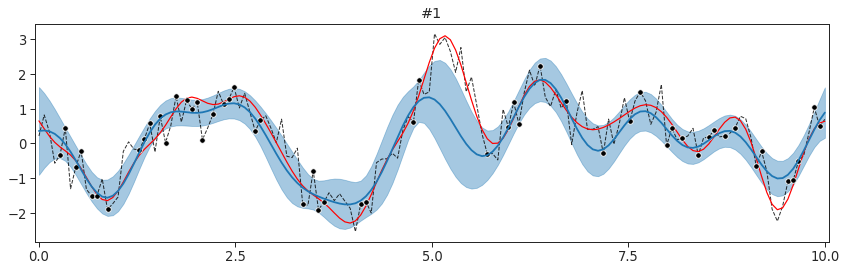

In [13]:
model.predict(t)
fig, ax = model.plot_prediction(figsize=(12, 4))
ax[0].plot(t, f_p, 'r')

In [18]:
sm_mae

array([0.33400486, 0.33400486])

In [14]:
sm_mae

array([0.33400486, 0.33400486])

### MOSM

In [20]:
n_trials = 5
n_s = 5

mosm_mae = np.zeros((n_trials, n_s + 1))

for n in range(n_trials):
    for s in range(n_s + 1):
        dataset = make_dataset(t,
                               f_p,
                               y_p,
                               sigma_n=sigma_n,
                               n_s=n_s,
                               s=s)
        dataset[0].remove_index(index)
        dataset[0].remove_index(index2)
        
        mosm = mogptk.MOSM(dataset, Q=1)
        mosm.init_parameters()
        
        mosm.train(maxiter=1600, tol=1e-20, verbose=True)
        
        y_pred, _, _ = mosm.predict([t]*(n_s + 1))
        
        mosm_mae[n, s] = np.abs(y_pred[0] - f_p).mean()
        
np.savetxt('r-mosm_comparison/13-04/mosm.csv', mosm_mae, delimiter=',')

Starting optimization
 >Model: MOSM
 >Channels: 6                    
 >Components: 1
 >Training points: 805
 >Parameters: 37
 >Initial NLL: 1168.877
Optimization finished in 3.30 minutes
 >Final NLL: 558.022 

Starting optimization
 >Model: MOSM
 >Channels: 6                    
 >Components: 1
 >Training points: 805
 >Parameters: 37
 >Initial NLL: 1168.850
Optimization finished in 4.21 minutes
 >Final NLL: 448.321 

Starting optimization
 >Model: MOSM
 >Channels: 6                    
 >Components: 1
 >Training points: 805
 >Parameters: 37
 >Initial NLL: 1156.147
Optimization finished in 3.17 minutes
 >Final NLL: 489.357 

Starting optimization
 >Model: MOSM
 >Channels: 6                    
 >Components: 1
 >Training points: 805
 >Parameters: 37
 >Initial NLL: 1222.326
Optimization finished in 4.16 minutes
 >Final NLL: 536.448 

Starting optimization
 >Model: MOSM
 >Channels: 6                    
 >Components: 1
 >Training points: 805
 >Parameters: 37
 >Initial NLL: 1288.585
Optimi

In [21]:
mosm_mae.mean(0)

array([0.67440087, 0.49482928, 0.39834172, 0.31312474, 0.32722898,
       0.23131055])

In [22]:
mosm_mae.std(0)

array([0.05224381, 0.12094994, 0.07167102, 0.06218585, 0.07664506,
       0.03798704])

In [23]:
mosm_mae.mean(0) - mosm_mae.std(0)

array([0.62215706, 0.37387934, 0.32667069, 0.25093889, 0.25058391,
       0.19332351])

In [25]:
np.round(mosm_mae, 3)

array([[0.642, 0.547, 0.37 , 0.282, 0.466, 0.286],
       [0.757, 0.292, 0.31 , 0.279, 0.23 , 0.188],
       [0.7  , 0.501, 0.478, 0.272, 0.308, 0.188],
       [0.603, 0.664, 0.488, 0.297, 0.312, 0.246],
       [0.67 , 0.469, 0.346, 0.436, 0.32 , 0.248]])

No handles with labels found to put in legend.


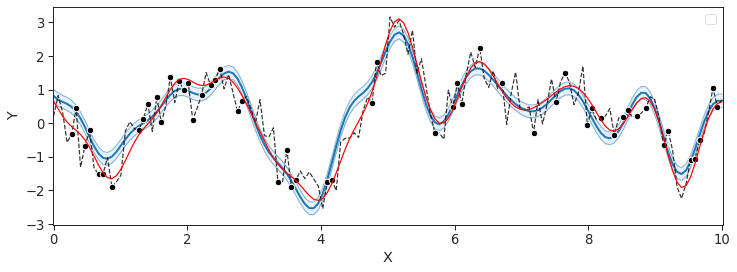

In [30]:
mosm.predict([t]*(n_s + 1))

ax = mosm.dataset[0].plot()
ax.plot(t, f_p, 'r')

### R-MOSM

In [24]:
Q_u = np.array([0] + [1] * n_s)
Q_p = 0
Q_s = 1

n_trials = 5
n_s = 5

rmosm_mae = np.zeros((n_trials, n_s + 1))
rmosm_list = []

for n in range(n_trials):
    for s in range(n_s + 1):
        dataset = make_dataset(t,
                               f_p,
                               y_p,
                               sigma_n=sigma_n,
                               n_s=n_s,
                               s=s)
        dataset[0].remove_index(index)
        dataset[0].remove_index(index2)
        
        rmosm = mogptk.RMOSM(dataset, Q_u=Q_u, Q_p=Q_p, Q_s=Q_s)
        rmosm.init_parameters()
        
        rmosm.train(maxiter=2000, tol=1e-20, verbose=True)
        rmosm_list.append(rmosm)
        
        y_pred, _, _ = rmosm.predict([t]*(n_s + 1))
        
        rmosm_mae[n, s] = np.abs(y_pred[0] - f_p).mean()
        
np.savetxt('r-mosm_comparison/13-04/rmosm_.csv', rmosm_mae, delimiter=',')

Starting optimization
 >Model: R-MOSM
 >Channels: 6                    
 >Components: 6
 >Training points: 805
 >Parameters: 52
 >Initial NLL: 1176.955
Optimization finished in 5.80 minutes
 >Final NLL: -127.096 

Starting optimization
 >Model: R-MOSM
 >Channels: 6                    
 >Components: 6
 >Training points: 805
 >Parameters: 52
 >Initial NLL: 1181.627
Optimization finished in 5.91 minutes
 >Final NLL: -56.021 

Starting optimization
 >Model: R-MOSM
 >Channels: 6                    
 >Components: 6
 >Training points: 805
 >Parameters: 52
 >Initial NLL: 1318.406
Optimization finished in 5.89 minutes
 >Final NLL: -125.526 

Starting optimization
 >Model: R-MOSM
 >Channels: 6                    
 >Components: 6
 >Training points: 805
 >Parameters: 52
 >Initial NLL: 1380.458
Optimization finished in 5.96 minutes
 >Final NLL: -133.162 

Starting optimization
 >Model: R-MOSM
 >Channels: 6                    
 >Components: 6
 >Training points: 805
 >Parameters: 52
 >Initial NLL: 12

In [35]:
mosm_mae.mean(0)

array([0.67440087, 0.49482928, 0.39834172, 0.31312474, 0.32722898,
       0.23131055])

In [25]:
rmosm_mae.mean(0)

array([0.37436157, 0.45005958, 0.32298697, 0.31409416, 0.22840557,
       0.24543614])

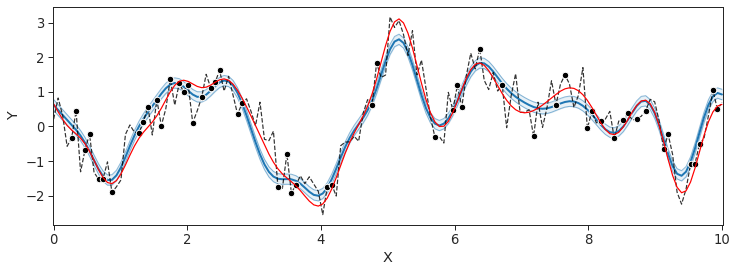

In [26]:
rmosm.predict([t]*(n_s + 1))

ax = rmosm.dataset[0].plot()
ax.plot(t, f_p, 'r')

### R-MOSM pairs

In [21]:
M = len(dataset)
Q_u = np.array([0] + [1] * n_s)
Q_p = 1
Q_s = 0

# prior = tfp.distributions.Laplace(loc=np.zeros(M), scale=np.ones(M) * 20)
n_trials = 1
n_s = 5

rmosm_p_mae = np.zeros((n_trials, n_s + 1))
rmosm_p_list = []

for n in range(n_trials):
    for s in range(n_s + 1):
        dataset = make_dataset(t,
                               f_p,
                               y_p,
                               sigma_n=sigma_n,
                               n_s=n_s,
                               s=s)
        dataset[0].remove_index(index)
        
        rmosm_p = mogptk.RMOSM(dataset, Q_u=Q_u, Q_p=Q_p, Q_s=Q_s)
        rmosm_p.init_parameters()
        
        rmosm_p.train(maxiter=2000, tol=1e-20, verbose=True)
        rmosm_p_list.append(rmosm_p)
        
        y_pred, _, _ = rmosm_p.predict([t]*(n_s + 1))
        
        rmosm_p_mae[n, s] = np.abs(y_pred[0] - f_p).mean()
        
np.savetxt('r-mosm_comparison/13-04/rmosm_p.csv', rmosm_mae, delimiter=',')

Starting optimization
 >Model: R-MOSM
 >Channels: 6                    
 >Components: 20
 >Training points: 810
 >Parameters: 172
 >Initial NLL: 1100.276
Optimization finished in 8.60 minutes
 >Final NLL: -48.561 

Starting optimization
 >Model: R-MOSM
 >Channels: 6                    
 >Components: 20
 >Training points: 810
 >Parameters: 172
 >Initial NLL: 1131.840
Optimization finished in 8.55 minutes
 >Final NLL: -89.400 

Starting optimization
 >Model: R-MOSM
 >Channels: 6                    
 >Components: 20
 >Training points: 810
 >Parameters: 172
 >Initial NLL: 1346.976
Optimization finished in 8.59 minutes
 >Final NLL: -115.185 

Starting optimization
 >Model: R-MOSM
 >Channels: 6                    
 >Components: 20
 >Training points: 810
 >Parameters: 172
 >Initial NLL: 1162.839
Optimization finished in 8.71 minutes
 >Final NLL: -187.241 

Starting optimization
 >Model: R-MOSM
 >Channels: 6                    
 >Components: 20
 >Training points: 810
 >Parameters: 172
 >Initia

In [ ]:
y_pred, ci_hi, ci_low = rmosm_p.predict([t]*(n_s + 1))


mask = rmosm.dataset[0].mask

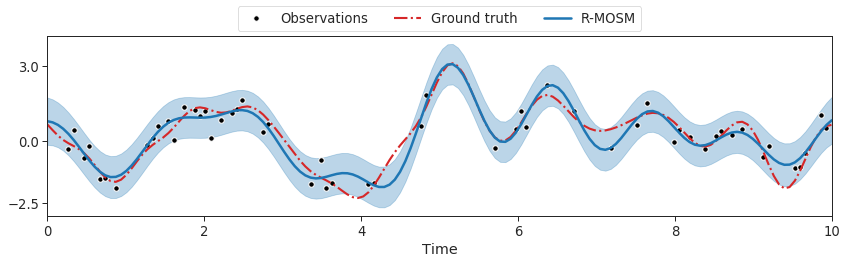

In [64]:
plt.figure(figsize=(12, 4))
plt.plot(t[mask], y_p[mask], '.k', label='Observations', ms=11, mew=1, mec='w')
plt.plot(t, f_p, '-.', label='Ground truth', lw=2.1, c=sns.color_palette()[3])
plt.plot(t, y_pred[0], label='R-MOSM', lw=2.5)
plt.fill_between(t, ci_hi[0], ci_low[0], alpha=0.3, color=sns.color_palette()[0])
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.2))
plt.xlim(0, 10)
plt.yticks([-2.5, 0, 3])

plt.xlabel('Time')

plt.tight_layout()
plt.savefig('r-mosm_comparison/13-04/rmosm_regresion.pdf')

## Save data

# Make plots

In [ ]:
import matplotlib.pytplot as plt
import seaborn as sns

In [22]:
plt.rcParamsDefault['figure.figsize'] = (12, 4)
sns.set_context('paper', font_scale=1.6)
sns.set_style('ticks')

In [29]:
sm_mae = np.loadtxt('r-mosm_comparison/12-04/sm.csv', delimiter=',')
mosm_mae = np.loadtxt('r-mosm_comparison/12-04/mosm.csv', delimiter=',')
# rmosm_mae = np.loadtxt('r-mosm_comparison/10-04/rmosm.csv', delimiter=',')

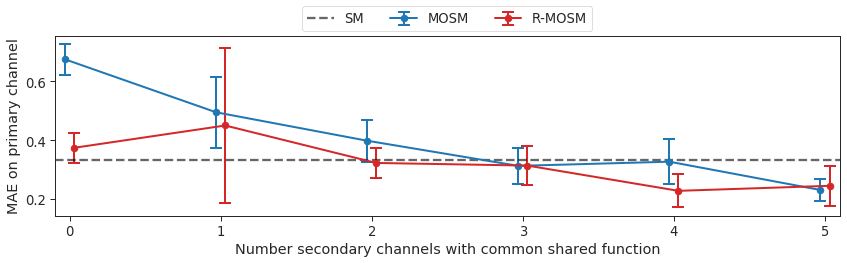

In [60]:
errorbar_args = {
    'capsize':6,
    'lw':2,
    'elinewidth':2,
    'capthick':2,
    'linestyle':'-',
    'marker':'.',
    'ms':13,
    }

plt.figure(figsize=(12, 4))
plt.errorbar(np.arange(6)-0.03,
             mosm_mae.mean(0),
             yerr=mosm_mae.std(0),
             label='MOSM',
             **errorbar_args)
plt.errorbar(np.arange(6)+0.03,
             rmosm_mae.mean(0),
             yerr=rmosm_mae.std(0),
             label='R-MOSM',
             **errorbar_args,
             c=sns.color_palette()[3])
plt.axhline(sm_mae.mean(), lw=2.3, ls='--', c='k', alpha=0.6, label='SM')

plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.2))
plt.xlabel('Number secondary channels with common shared function')
plt.ylabel('MAE on primary channel')
plt.xlim(-.1, 5.1)

plt.tight_layout()

plt.savefig('r-mosm_comparison/13-04/comparison.pdf')

In [70]:
def convert_tuple(*args):
    """
    Receibes tuples of the form 
    (step, n infected)
    
    Returns a n-tuple with n-infected elements 
    for each step
    """
    
    res = []
    for tup in args:
        assert tup[1] > 0

        res += [tup[0]] * tup[1]
    return tuple(res)
        
convert_tuple((0, 20), (1, 2), )

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1)